<a href="https://colab.research.google.com/github/Julianfried/Diplomatura-en-IA-Instituto-Humai/blob/main/NLP/Introducci%C3%B3n_a_Procesamiento_de_Lenguaje_Natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/NLP/1_Introduccion/ejercicios/ejercicios.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

## LSA

El **"Análisis Semántico Latente"** es una técnica para cuantificar el contenido y significado de documentos que fue extensamente utilizada desde su origen en la década de 1980.

El procedimiento es el siguiente:
- Computar dado un corpus de textos una matriz de co-ocurrencias.  
- Aplicar una reducción de dimensionalidad sobre esa matriz.
- Esto nos otorga ***embeddings***, o vectores de palabras, y de documentos, que resumen su significado. Con los mismos podemos operar en el "espacio latente".

**Descargar corpus de textos**

In [ ]:
#@title Preparamos Dataset de Medios de LatAm
%%capture
!pip install datasets
import pandas as pd
from datasets import load_dataset

data = pd.DataFrame()
configs = ['ar', 'bo', 'br', 'cl', 'co', 'cr', 'gt', 'hn', 'mx', 'ni', 'pa', 'pe', 'pr', 'py', 'sv', 'uy', 've'] # 'com', 'es'
for c in configs:
  data_ = load_dataset("LeoCordoba/CC-NEWS-ES", c)
  data = data.append(data_['train'].to_pandas())

data = data.drop('id', axis=1).reset_index(drop=True)
# Hacemos "downsampling" tomando maximo n_min para
# los grupos que tienen > n_min, y todos para los que tienen menos
n_min = 1000
df_grouped = data.groupby("country")
df_grouped.groups.values()
frames_of_groups = [x.sample(n_min) if x.shape[0] > n_min else x for y, x in df_grouped]
data = pd.concat(frames_of_groups)

In [ ]:
# Ejecutar la celda de arriba para preparar los datos
print(data.shape[0])
data.sample(2)

15561


,country,text
1797410,uy,"Voz de incontables adolescencias, figura de la..."
1706370,pe,"“Fueron 15 años hermosos, basados en la comuni..."


In [ ]:
data.country.value_counts()

ar    1000
bo    1000
uy    1000
py    1000
pr    1000
pe    1000
pa    1000
ni    1000
mx    1000
hn    1000
gt    1000
cr    1000
co    1000
cl    1000
ve    1000
sv     454
br     107
Name: country, dtype: int64

**Buscar los N términos más frecuentes**

(pueden hacerlo con lo que prefieran: Python base, con NLTK, con collections.Counter...)

In [ ]:
!pip install stop_words
import stop_words
stop_words = stop_words.get_stop_words('es')


In [ ]:
import itertools
import re
from collections import Counter

n = 20

words = data.text.str.lower().str.findall("[A-zA-ú]+").tolist()

words = list(itertools.chain(*words))

words = [w for w in words if not re.match('(\d+)', w) and w not in stop_words]
word_counts= Counter(words)

In [ ]:
word_counts.most_common()[:n]

[('años', 7903),
 ('si', 6619),
 ('ser', 6186),
 ('país', 6086),
 ('dos', 5493),
 ('nacional', 5449),
 ('parte', 5113),
 ('año', 5034),
 ('personas', 4991),
 ('gobierno', 4928),
 ('dijo', 4838),
 ('presidente', 4551),
 ('según', 4173),
 ('así', 3965),
 ('millones', 3729),
 ('además', 3688),
 ('vida', 3542),
 ('hace', 3427),
 ('puede', 3335),
 ('vez', 3320)]

**Repetir quitando stop words***

In [ ]:
words2 = [w for w in words if not re.match('(\d+)', w)]
word_counts2= Counter(words2)
word_counts2.most_common()[:n]

[('años', 7903),
 ('si', 6619),
 ('ser', 6186),
 ('país', 6086),
 ('dos', 5493),
 ('nacional', 5449),
 ('parte', 5113),
 ('año', 5034),
 ('personas', 4991),
 ('gobierno', 4928),
 ('dijo', 4838),
 ('presidente', 4551),
 ('según', 4173),
 ('así', 3965),
 ('millones', 3729),
 ('además', 3688),
 ('vida', 3542),
 ('hace', 3427),
 ('puede', 3335),
 ('vez', 3320)]

**Aplicar TF-IDF**:

- Usar la clase de sklearn
- Utilizar hasta 2 ngramas
- Utilizar los parámetros de TF-IDF para descartar tokens que aparezcan "poco" (definirlo con esos parámetros)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000, min_df=2, stop_words=stop_words)

X = vectorizer.fit_transform(data.text)

print('n_samples: %d, n_features: %d'% X.shape)


n_samples: 15561, n_features: 10000


In [ ]:
X

array([[ 7.00930942e-01,  6.48855699e-02, -2.01324467e-01, ...,
        -1.00641300e-01, -7.56406581e-02,  4.11751468e-03],
       [ 3.82755505e-01,  2.33648983e-02, -1.32046539e-01, ...,
         6.50774794e-02,  2.06152670e-02,  2.40952254e-02],
       [ 2.72083231e-01, -1.84788201e-05, -5.82456044e-02, ...,
         7.94549399e-02, -3.71976075e-02,  1.02062192e-01],
       ...,
       [ 3.41015756e-01, -8.02249800e-03,  1.22174376e-01, ...,
        -1.19174322e-01,  1.63938095e-01,  1.27017390e-01],
       [ 2.69618317e-01,  1.98964961e-01, -7.93309256e-02, ...,
        -8.74358683e-02,  9.47511004e-03,  2.68258001e-02],
       [ 2.29218301e-01,  5.90826830e-02, -4.36726260e-02, ...,
         1.14465910e-01,  2.55649506e-02,  1.62108614e-01]])

In [ ]:
svd = TruncatedSVD(100, random_state=1)
normalizer=Normalizer(copy=False)
lsa=make_pipeline(svd,normalizer)
X=lsa.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans
k=10
km = KMeans(n_clusters=k, max_iter=100, n_init=10, random_state = 1)
km.fit(X)

KMeans(max_iter=100, n_clusters=10, n_init=10, random_state=1)

In [ ]:
original_space_centroids = svd.inverse_transform(km.cluster_centers_)

order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = vectorizer.get_feature_names_out()

print("Ranking")

for i in range(k):
  print("Topico %d" %i, end='')
  for ind in order_centroids[i, :10]:
    print(' %s' % terms[ind],end='')
  print()

Ranking
Topico 0 venezuela maduro guaidó presidente gobierno venezolano país nicolás venezolanos países
Topico 1 si vida ser siempre gente bien años cosas día hacer
Topico 2 unidos país panamá 2019 ciudad año méxico dijo años personas
Topico 3 policía años según lugar dos san personas zona mujer hombre
Topico 4 salud desarrollo país educación año parte trabajo personas además nacional
Topico 5 película música años the historia mejor artista cine musical parte
Topico 6 gobierno presidente partido electoral nacional dijo elecciones país política ley
Topico 7 justicia fiscal caso fiscalía tribunal juez corte penal público juicio
Topico 8 millones dólares 000 us mil año pesos 2018 años según
Topico 9 equipo partido final copa dos club liga fútbol gol juego


**Aplicar clustering sobre los documentos, usando la matriz de TF-IDF.**

Pueden usar cualquier algorítmo de clustering (KMeans, HDBscan...)

**Visualizar los clusters, en 2D o en 3D**

Con matplotlib, seaborn o plotly

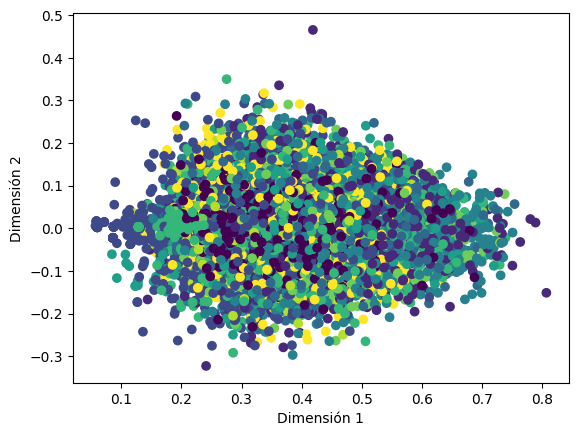

In [ ]:
plt.figure()
plt.scatter(X[:,0], X[:,-1], c=km.labels_)
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.show()

**Buscar las palabras más frecuentes por cluster**

## Extra:

Ver Social Listening en Twitter en [este Colab](https://github.com/institutohumai/talleres/blob/master/Twitter_Social_Listening_ejemplo.ipynb), que tiene un proceso muy completo de NLP, incluyendo visualización de clusters en 3D y word clouds :)
